### Object detection and segmentation using pytorch
This example will use the Penn-Fudan dataset to demonstrate object detection and segmentation using pytorch.

#### Prepare the dataset

In [6]:
#download the zipped dataset and decompress it on data folder
## download if not present
import os
if not os.path.exists('./data/pennfudan'):
    !mkdir data/pennfudan/
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data/pennfudan/
    #unzip the dataset
    !unzip data/pennfudan/PennFudanPed.zip -d data/pennfudan/
else:
    print('Dataset already present')

Dataset already present


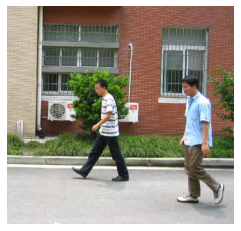

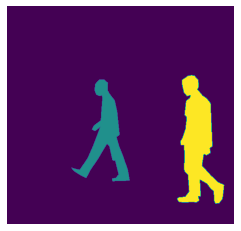

In [183]:
#import PIL
import PIL
from PIL import Image
import matplotlib.pyplot as plt

img_path = './data/pennfudan/PennFudanPed/PNGImages/FudanPed00001.png'
mask_path = './data/pennfudan/PennFudanPed/PedMasks/FudanPed00001_mask.png'
img = Image.open(img_path)
img_mask = Image.open(mask_path)

#Don't show axis
plt.axis('off')
#show the image and mask
plt.imshow(img)
plt.show()
plt.axis('off')
plt.imshow(img_mask)
plt.show()

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
def plot_box(box):
    plt.gca().add_patch(Rectangle((box[0], box[1]) ,box[2] - box[0], box[3] - box[1],
                    edgecolor='red',
                    facecolor='none',
                    lw=2));


In [209]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch


class PennFudanDataset(Dataset):
    def __init__(self, root_dir, transforms) -> None:
        super().__init__()
        self.root = root_dir
        self.transforms = transforms
        self.imgs_names = sorted(os.listdir(os.path.join(self.root, "PNGImages")))
        self.masks_names = sorted(os.listdir(os.path.join(self.root, "PedMasks")))

    def __getitem__(self, index):
        img_path = os.path.join(self.root, "PNGImages", self.imgs_names[index])
        mask_path = os.path.join(self.root, "PedMasks", self.masks_names[index])
        img = Image.open(img_path)
        mask = np.array(Image.open(mask_path))

        object_ids = np.unique(mask)[1:]
        num_objs = len(object_ids)
        masks = (mask == object_ids[:, None, None]) #Generate a matrix of binary masks, one for each mask
        boxes = self.generate_bounding_boxes(masks)

        labels = torch.ones((num_objs,), dtype=torch.int64) # for 2 objects: [1,1] beacuse there is only one class
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # suppose all instances are not crowd
        boxes_pt = torch.as_tensor(boxes, dtype=torch.float32)
        masks_pt = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([index])
        areas = (boxes_pt[:, 3] - boxes_pt[:, 1]) * (boxes_pt[:, 2] - boxes_pt[:, 0])

        target = {}
        target["boxes"] = boxes_pt
        target["labels"] = labels
        target["masks"] = masks_pt
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def generate_bounding_boxes(self, masks):
        num_objects = masks.shape[0]
        boxes = []
        for i in range(num_objects):
            y_coord, x_coord = np.where(masks[i])
            x_min = np.min(x_coord)
            x_max = np.max(x_coord)
            y_min = np.min(y_coord)
            y_max = np.max(y_coord)
            boxes.append([x_min, y_min, x_max, y_max])  
        return boxes      

    def __len__(self):
        return len(self.imgs_names)       

root_dir = './data/pennfudan/PennFudanPed'

        

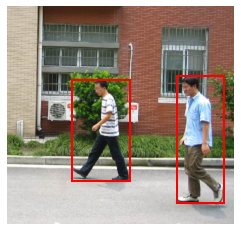

In [217]:
ds = PennFudanDataset(root_dir, None)
img, target = ds[0]
plt.imshow(img); plt.axis('off');
for i in range(target["boxes"].shape[0]):
    plot_box(target["boxes"][i].numpy())